# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

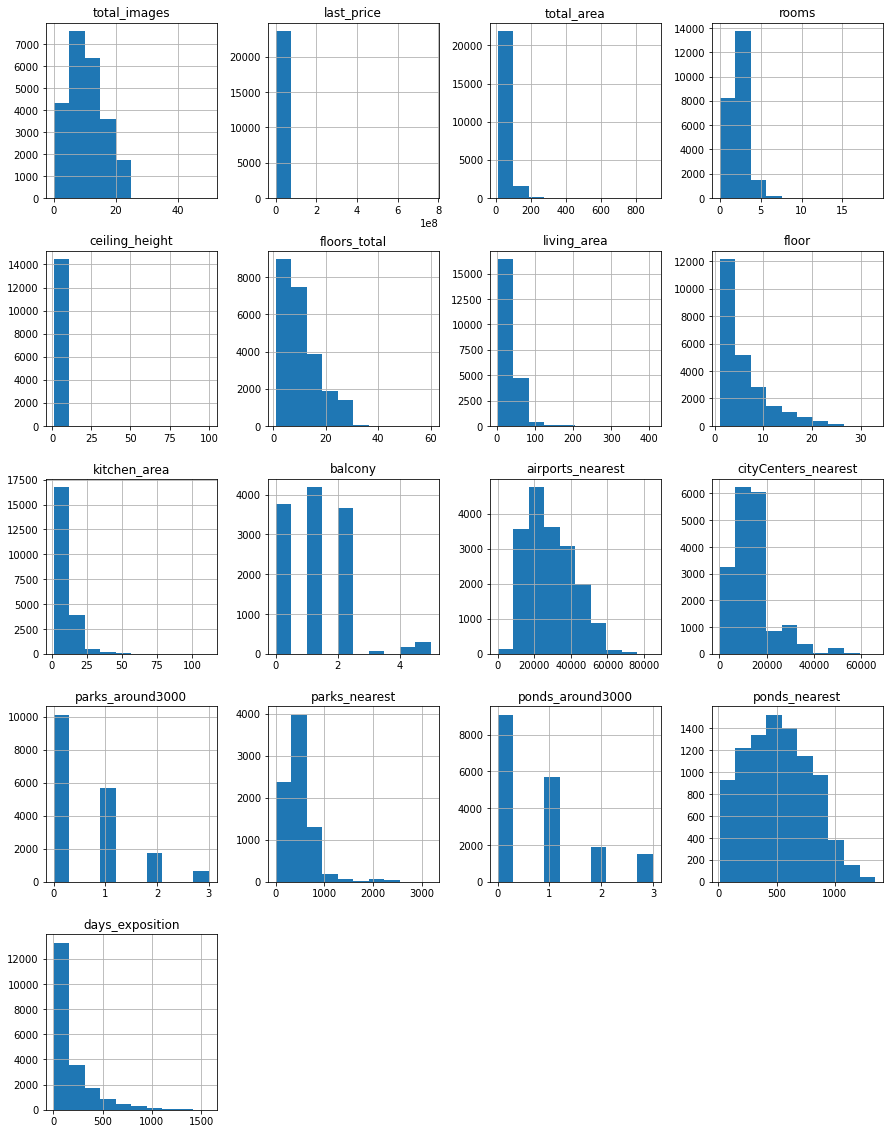

In [5]:
df.hist(figsize=(15, 20));

### Предобработка данных

In [6]:
df.isna().sum().sort_values()

total_images                0
open_plan                   0
floor                       0
rooms                       0
studio                      0
total_area                  0
last_price                  0
first_day_exposition        0
locality_name              49
floors_total               86
living_area              1903
kitchen_area             2278
days_exposition          3181
ponds_around3000         5518
parks_around3000         5518
cityCenters_nearest      5519
airports_nearest         5542
ceiling_height           9195
balcony                 11519
ponds_nearest           14589
parks_nearest           15620
is_apartment            20924
dtype: int64

In [9]:
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['balcony'] = df['balcony'].fillna(0)
df['is_apartment'] = df['is_apartment'].fillna(False)
df['locality_name'] = df['locality_name'].fillna(' ')
df = df.dropna(subset = ['floors_total'])

In [10]:
df.isna().sum().sort_values()

total_images                0
ponds_around3000            0
parks_around3000            0
locality_name               0
balcony                     0
open_plan                   0
is_apartment                0
floor                       0
studio                      0
floors_total                0
rooms                       0
first_day_exposition        0
total_area                  0
last_price                  0
living_area              1870
kitchen_area             2231
days_exposition          3172
cityCenters_nearest      5509
airports_nearest         5532
ceiling_height           9118
ponds_nearest           14552
parks_nearest           15568
dtype: int64

Пропуски в столбцах `ponds_around3000`, `parks_around3000` и `balcony` возможны из-за отсутствия балконов, и водоёмов и парков в радиусе 3 км. В столбце `is_apartment` пропуски вероятны в следствии того, что малый процент квартир является апартаментами, поэтому данный параметр редко указывают.

In [11]:
df['is_apartment'] = df['is_apartment'].astype('bool')
df['balcony'] = df['balcony'].astype('int')
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
df['floors_total'] = df['floors_total'].astype('int')
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

In [12]:
df['locality_name'].sort_values().unique()

array([' ', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок 

In [13]:
len(df['locality_name'].unique())

365

In [14]:
def new_name(name):
    n = name.replace('посёлок', 'поселок', )
    n = n.replace('поселок городского типа', 'поселок')
    n = n.replace('городской поселок', 'поселок')    
    return n
    
df['new_locality_name'] = df['locality_name'].apply(new_name)
    
df['new_locality_name'] = df['new_locality_name'].replace('поселок Мурино', 'Мурино')
df['new_locality_name'] = df['new_locality_name'].replace('село Никольское', 'Никольское')
df['new_locality_name'] = df['new_locality_name'].replace('поселок Любань', 'Любань')
df['new_locality_name'] = df['new_locality_name'].replace('деревня Кудрово', 'Кудрово')
df['new_locality_name'] = df['new_locality_name'].replace('село Павлово', 'поселок Павлово')
df['new_locality_name'] = df['new_locality_name'].replace('садовое товарищество Приладожский', 'поселок Приладожский')
df['new_locality_name'] = df['new_locality_name'].replace('поселок при железнодорожной станции Приветнинское', 'поселок станции Приветнинское')
df['new_locality_name'] = df['new_locality_name'].replace('поселок при железнодорожной станции Вещево', 'поселок станции Вещево')
df['new_locality_name'] = df['new_locality_name'].replace('садовое товарищество Рахья', 'поселок Рахья')
    
df['new_locality_name'].sort_values().unique()

array([' ', 'Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выс

In [15]:
df.new_locality_name.nunique()

314

In [16]:
# check
df.locality_name.nunique()

365

In [17]:
data_f = df.copy()

In [18]:
data_f['ceiling_height'].describe()

count    14495.000000
mean         2.771495
std          1.261445
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

[]

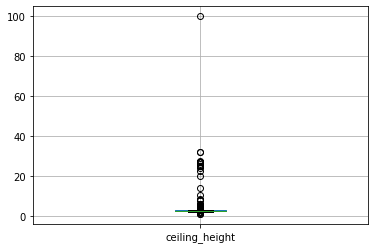

In [19]:
box_plot = data_f.boxplot(column = 'ceiling_height')

box_plot.plot()

[]

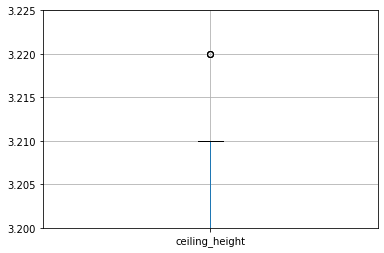

In [20]:
box_plot = data_f.boxplot(column = 'ceiling_height')

plt.ylim(3.2,3.225)

box_plot.plot()

In [21]:
data_f['rooms'].describe()

count    23613.000000
mean         2.071147
std          1.078380
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

[]

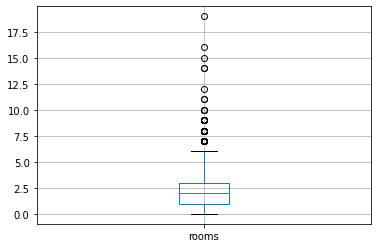

In [22]:
box_plot = data_f.boxplot('rooms')

box_plot.plot()

[]

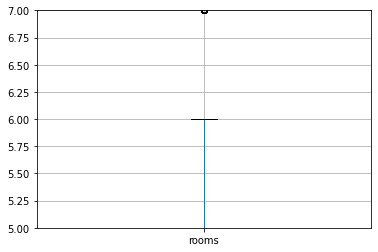

In [23]:
box_plot = data_f.boxplot('rooms')

plt.ylim(5,7)

box_plot.plot()

In [24]:
data_f['total_area'].describe()

count    23613.000000
mean        60.340678
std         35.648988
min         12.000000
25%         40.000000
50%         52.000000
75%         69.800000
max        900.000000
Name: total_area, dtype: float64

[]

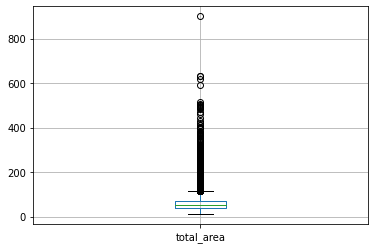

In [25]:
box_plot = data_f.boxplot('total_area')

box_plot.plot()

[]

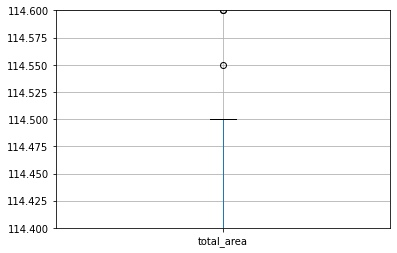

In [27]:
box_plot = data_f.boxplot('total_area')

plt.ylim(114.4,114.6)

box_plot.plot()

[]

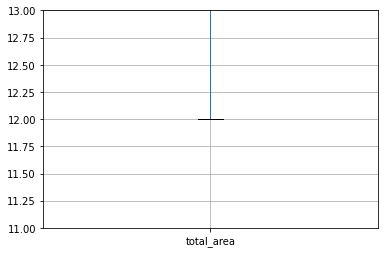

In [28]:
box_plot = data_f.boxplot('total_area')

plt.ylim(11,13)

box_plot.plot()

In [29]:
data_f['days_exposition'].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

[]

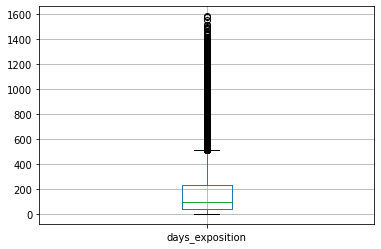

In [30]:
box_plot = data_f.boxplot('days_exposition')

box_plot.plot()

[]

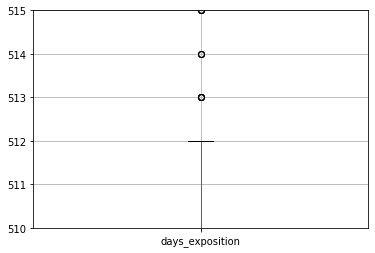

In [31]:
box_plot = data_f.boxplot('days_exposition')

plt.ylim(510,515)

box_plot.plot()

[]

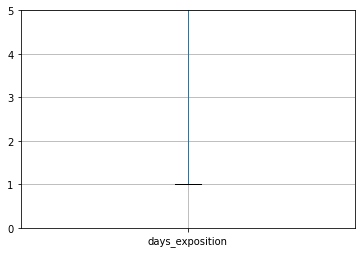

In [32]:
box_plot = data_f.boxplot('days_exposition')

plt.ylim(0,5)

box_plot.plot()

In [33]:
data_f['last_price'].describe()

count    2.361300e+04
mean     6.540555e+06
std      1.090172e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

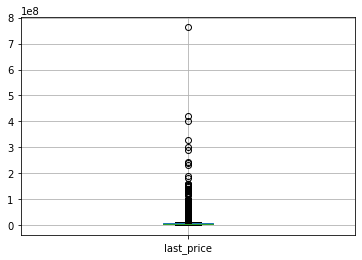

In [34]:
box_plot = data_f.boxplot('last_price')

box_plot.plot();

In [35]:
data_f['last_price'].quantile([0.01, 0.99])

0.01     1000000.0
0.99    36000000.0
Name: last_price, dtype: float64

In [36]:
data_f['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

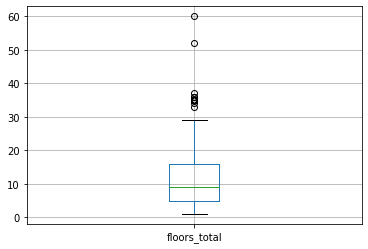

In [37]:
box_plot = data_f.boxplot('floors_total')

box_plot.plot();

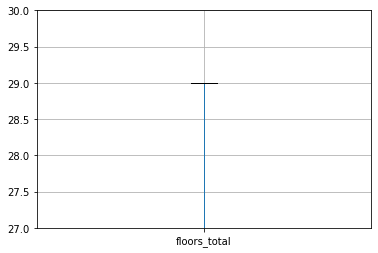

In [38]:
box_plot = data_f.boxplot('floors_total')

plt.ylim(27,30)

box_plot.plot();

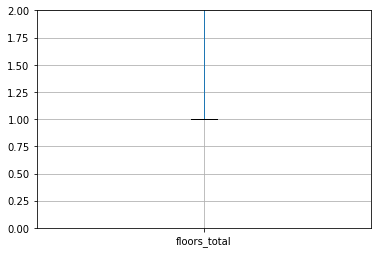

In [39]:
box_plot = data_f.boxplot('floors_total')

plt.ylim(0,2)

box_plot.plot();

In [40]:
data_f['living_area'].describe()

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

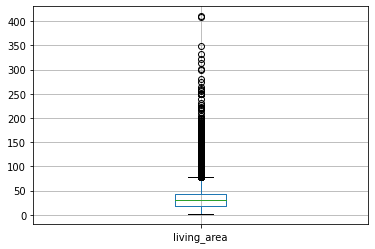

In [41]:
box_plot = data_f.boxplot('living_area')

box_plot.plot();

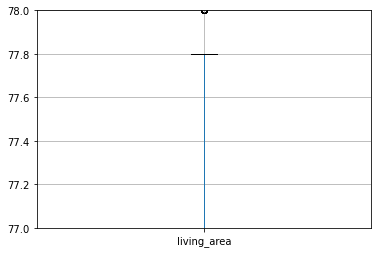

In [42]:
box_plot = data_f.boxplot('living_area')

plt.ylim(77,78)

box_plot.plot();

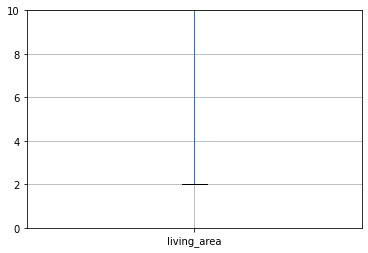

In [43]:
box_plot = data_f.boxplot('living_area')

plt.ylim(0,10)

box_plot.plot();

In [44]:
data_f['kitchen_area'].describe()

count    21382.000000
mean        10.564128
std          5.904316
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

[]

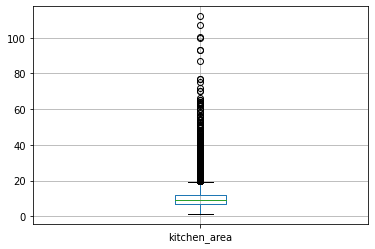

In [45]:
box_plot = data_f.boxplot('kitchen_area')

box_plot.plot()

[]

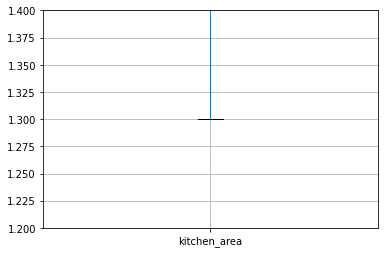

In [46]:
box_plot = data_f.boxplot('kitchen_area')

plt.ylim(1.2,1.4)

box_plot.plot()

[]

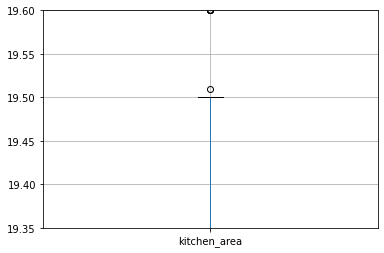

In [47]:
box_plot = data_f.boxplot('kitchen_area')

plt.ylim(19.35,19.60)

box_plot.plot()

In [48]:
data_f['kitchen_area'].isna().sum()

2231

In [49]:
data_f['floor'].describe()

count    23613.000000
mean         5.877313
std          4.873539
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

[]

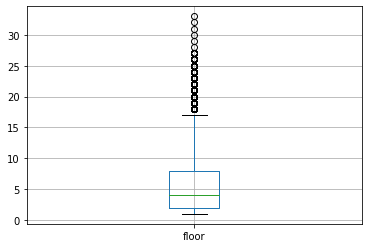

In [50]:
box_plot = data_f.boxplot('floor')

box_plot.plot()

[]

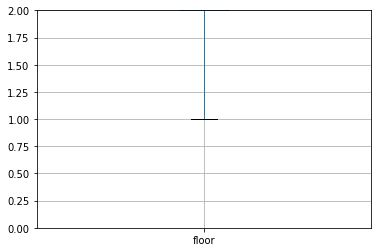

In [51]:
box_plot = data_f.boxplot('floor')

plt.ylim(0,2)

box_plot.plot()

[]

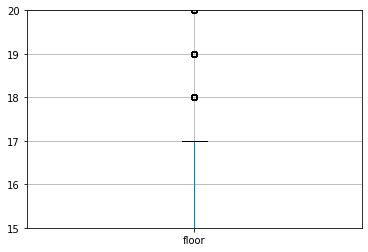

In [52]:
box_plot = data_f.boxplot('floor')

plt.ylim(15,20)

box_plot.plot()

In [53]:
data_f['floor'].isna().sum()

0

In [54]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

In [55]:
data_f = data_f[data_f['airports_nearest'] != 0]

data_f.loc[data_f['last_price'] == 12190.0, 'last_price'] = 12190000 
data_f = data_f[(data_f['last_price'] >= 1000000.0) & (data_f['last_price'] <= 36000000.0)]

data_f.loc[data_f['floors_total'] == 60, 'floors_total'] = 6
data_f = data_f[(data_f['floors_total'] >= 1) & (data_f['floors_total'] <= 29)]

data_f= data_f[(data_f['ceiling_height'] >= 2.4) | (data_f['ceiling_height'].isna())]
data_f.loc[data_f['ceiling_height'] == 24, 'ceiling_height'] = 2.4
data_f.loc[data_f['ceiling_height'] == 25, 'ceiling_height'] = 2.5
data_f.loc[data_f['ceiling_height'] == 26, 'ceiling_height'] = 2.6
data_f.loc[data_f['ceiling_height'] == 27,'ceiling_height'] = 2.7
data_f.loc[data_f['ceiling_height'] == 27.5, 'ceiling_height'] = 2.75
data_f.loc[data_f['ceiling_height'] == 32, 'ceiling_height'] = 3.2
data_f = data_f[(data_f['ceiling_height'] <= 3.21) | (data_f['ceiling_height'].isna())]

data_f = data_f[data_f['rooms'] <= 6]

data_f = data_f[data_f['total_area'] <= 114.5]

data_f = data_f[((data_f['days_exposition'] <= 512) & (data_f['days_exposition'] >= 1)) | (data_f['days_exposition'].isna())]

data_f = data_f[(data_f['living_area'] >= 2) & (data_f['living_area'] <= 77.8)]

data_f = data_f[((data_f['kitchen_area'] <= 19.5) & (data_f['kitchen_area'] >= 1.3)) | (data_f['kitchen_area'].isna())]
        
data_f = data_f[(data_f['floor'] >= 1) & (data_f['floor'] <= 17)]

data_f.reset_index(drop= True , inplace= True )

In [56]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17308 entries, 0 to 17307
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          17308 non-null  int64         
 1   last_price            17308 non-null  float64       
 2   total_area            17308 non-null  float64       
 3   first_day_exposition  17308 non-null  datetime64[ns]
 4   rooms                 17308 non-null  int64         
 5   ceiling_height        10765 non-null  float64       
 6   floors_total          17308 non-null  int64         
 7   living_area           17308 non-null  float64       
 8   floor                 17308 non-null  int64         
 9   is_apartment          17308 non-null  bool          
 10  studio                17308 non-null  bool          
 11  open_plan             17308 non-null  bool          
 12  kitchen_area          16669 non-null  float64       
 13  balcony         

Таким образом потери записей составляют почти 30%. Поэтому будем использовать другой метод.

In [57]:
(df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.9988]))

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.0,20.0,2.3,3.00,5.616720e+05,10.0000,3.8,1.0,2.0
0.9988,8.0,380.0,25.0,1370.36,1.248261e+08,219.8192,60.0,26.0,35.0


#### check nan

In [58]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23613 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23613 non-null  int64         
 1   last_price            23613 non-null  float64       
 2   total_area            23613 non-null  float64       
 3   first_day_exposition  23613 non-null  datetime64[ns]
 4   rooms                 23613 non-null  int64         
 5   ceiling_height        14495 non-null  float64       
 6   floors_total          23613 non-null  int64         
 7   living_area           21743 non-null  float64       
 8   floor                 23613 non-null  int64         
 9   is_apartment          23613 non-null  bool          
 10  studio                23613 non-null  bool          
 11  open_plan             23613 non-null  bool          
 12  kitchen_area          21382 non-null  float64       
 13  balcony         

In [59]:
df = df[(df['living_area'] >= 10.0) & (df['living_area'] <= 219.8192)]

In [60]:
# check
df.shape[0]

21691

In [61]:
df = df[df['airports_nearest'] != 0]

df.loc[df['last_price'] == 12190.0, 'last_price'] = 12190000 
df = df[(df['last_price'] >= 561672.0) & (df['last_price'] <= 1.248261e+08)]

df.loc[df['floors_total'] == 60, 'floors_total'] = 6
df = df[(df['floors_total'] >= 2) & (df['floors_total'] <= 35)]

df= df[(df['ceiling_height'] >= 2.3) | (df['ceiling_height'].isna())]
df.loc[df['ceiling_height'] == 24, 'ceiling_height'] = 2.4
df.loc[df['ceiling_height'] == 25, 'ceiling_height'] = 2.5
df.loc[df['ceiling_height'] == 26, 'ceiling_height'] = 2.6
df.loc[df['ceiling_height'] == 27,'ceiling_height'] = 2.7
df.loc[df['ceiling_height'] == 27.5, 'ceiling_height'] = 2.75
df.loc[df['ceiling_height'] == 32, 'ceiling_height'] = 3.2
df.loc[df['ceiling_height'] == 100, 'ceiling_height'] = 10
df = df[(df['ceiling_height'] <= 3.8306) | (df['ceiling_height'].isna())]

df = df[(df['rooms'] >= 0) & (df['rooms'] <= 8)]

df = df[(df['total_area'] >= 20) & (df['total_area'] <= 380)]

df = df[((df['days_exposition'] <= 1370.0) & (df['days_exposition'] >= 3.0)) | (df['days_exposition'].isna())]

# df = df[(df['living_area'] >= 10.0) & (df['living_area'] <= 219.8192)]

df = df[((df['kitchen_area'] <= 60) & (df['kitchen_area'] >= 3.8)) | (df['kitchen_area'].isna())]
        
df = df[(df['floor'] >= 1) & (df['floor'] <= 26)]

df.reset_index(drop= True , inplace= True )

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21408 entries, 0 to 21407
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21408 non-null  int64         
 1   last_price            21408 non-null  float64       
 2   total_area            21408 non-null  float64       
 3   first_day_exposition  21408 non-null  datetime64[ns]
 4   rooms                 21408 non-null  int64         
 5   ceiling_height        13454 non-null  float64       
 6   floors_total          21408 non-null  int64         
 7   living_area           21408 non-null  float64       
 8   floor                 21408 non-null  int64         
 9   is_apartment          21408 non-null  bool          
 10  studio                21408 non-null  bool          
 11  open_plan             21408 non-null  bool          
 12  kitchen_area          20634 non-null  float64       
 13  balcony         

Потери чуть меньше 10%

***При изучении таблицы выявились аномалии в нескольких столбцах:***
- Во-первых, пришлось удалить строки, в которых расстояние до аэропорта `airports_nearest` равно 0;
- Во-вторых, обнаружилась квартира с удивительной стоимостью в 12 тысяч 190 рублей, изучив её параметры, я посчитал что такую стоимость можно заменить на 12 миллионов 190 тысяч рублей;
- В-третьих, мной была замечена квартира в доме с 60-ю этажами, подобных жилых сооружений в СПб и ЛО я не обнаружил, поэтому заменил количество этажей на 6;
- И в-четвёртых, я удалил все строки с высотой потолков `ceiling_height` ниже минимальных 2.3 метров и выше 3.8 метров, а также заменил все варианты вроде 24, 25 и 26 метров на 2.4, 2.5 и 2.6 метров соответственно.
- Ну и наконец, с помощью квантилей находим границы для колонок, внутри которых находятся данные без аномалий и редкостей. Потери данных составили чуть меньше 10%

#### check gap

In [63]:
# check
data = df.copy()

In [64]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21408 entries, 0 to 21407
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21408 non-null  int64         
 1   last_price            21408 non-null  float64       
 2   total_area            21408 non-null  float64       
 3   first_day_exposition  21408 non-null  datetime64[ns]
 4   rooms                 21408 non-null  int64         
 5   ceiling_height        13454 non-null  float64       
 6   floors_total          21408 non-null  int64         
 7   living_area           21408 non-null  float64       
 8   floor                 21408 non-null  int64         
 9   is_apartment          21408 non-null  bool          
 10  studio                21408 non-null  bool          
 11  open_plan             21408 non-null  bool          
 12  kitchen_area          20634 non-null  float64       
 13  balcony         

In [65]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"21,408.00","21,408.00","13,454.00","18,487.00","21,408.00","21,408.00","20,634.00","21,408.00","21,408.00"
min,0.00,20.00,2.30,3.00,"565,000.00",10.00,3.80,1.00,2.00
max,8.00,380.00,3.83,"1,368.00","124,480,000.00",211.00,60.00,26.00,35.00
median,2.00,52.00,2.65,100.00,"4,645,000.00",30.00,9.00,4.00,9.00


In [66]:
# check

try:
    df_check = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
# если не получилось прочитать файл из локальной папки, то загружаем данные из сети
except:
    df_check = pd.read_csv('real_estate_data.csv', sep='\t')

In [67]:
# check
df_check.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


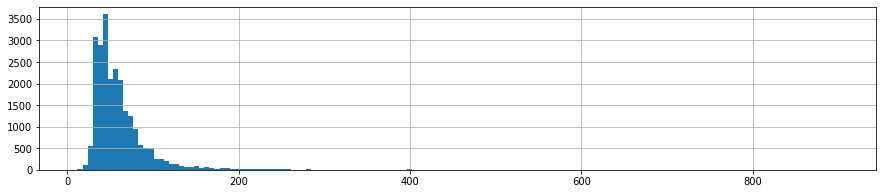

In [68]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3));

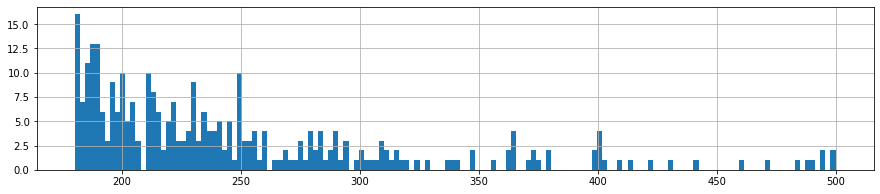

In [69]:
# check
df_check.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

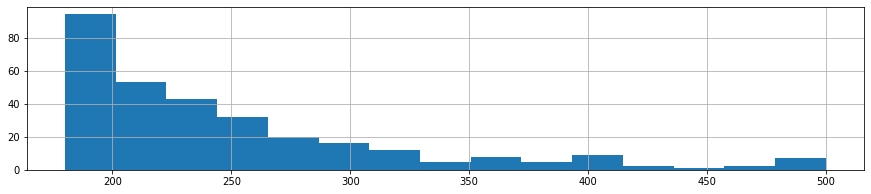

In [70]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (180,500));

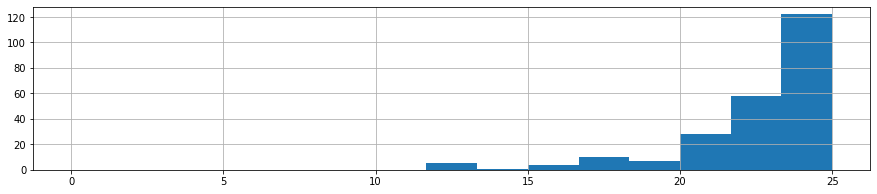

In [71]:
# check
df_check.total_area.hist(bins = 15, figsize = (15,3), range = (0,25));

In [72]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.0012,0.00,21.97,2.40,3.00,"650,000.00",10.00,4.00,1.00,2.00
0.01,1.00,26.00,2.50,4.00,"1,100,000.00",13.30,5.00,1.00,2.00
0.5,2.00,52.00,2.65,100.00,"4,645,000.00",30.00,9.00,4.00,9.00
0.99,5.00,175.93,3.54,"1,047.14","29,999,930.00",106.19,32.77,22.00,26.00
0.9988,7.00,280.34,3.80,"1,308.27","69,707,450.00",174.52,49.25,25.00,28.00


### Посчитайте и добавьте в таблицу новые столбцы

In [73]:
def floor_definition(floors):
    if floors['floor'] == 1:
        return 'первый'
    elif floors['floor'] == floors['floors_total']:
        return 'последний'
    return 'другой'

df['square_meter_price'] = df['last_price']/df['total_area']
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year
df['type_floor'] = df.apply(floor_definition, axis=1)
df['km_to_center'] = round(df['cityCenters_nearest']/1000)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21408 entries, 0 to 21407
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21408 non-null  int64         
 1   last_price            21408 non-null  float64       
 2   total_area            21408 non-null  float64       
 3   first_day_exposition  21408 non-null  datetime64[ns]
 4   rooms                 21408 non-null  int64         
 5   ceiling_height        13454 non-null  float64       
 6   floors_total          21408 non-null  int64         
 7   living_area           21408 non-null  float64       
 8   floor                 21408 non-null  int64         
 9   is_apartment          21408 non-null  bool          
 10  studio                21408 non-null  bool          
 11  open_plan             21408 non-null  bool          
 12  kitchen_area          20634 non-null  float64       
 13  balcony         

### Проведите исследовательский анализ данных

<AxesSubplot:>

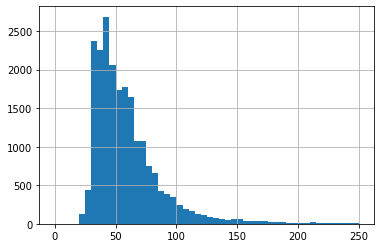

In [74]:
df['total_area'].hist(bins=50, range=(0,250))

<AxesSubplot:>

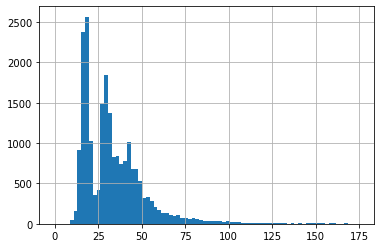

In [75]:
df['living_area'].hist(bins=80, range=(0,175))

<AxesSubplot:>

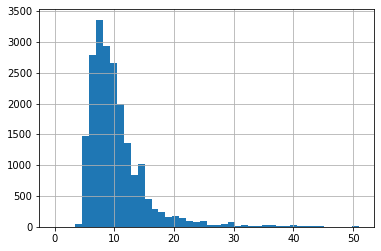

In [76]:
df['kitchen_area'].hist(bins=44, range=(0,51))

<AxesSubplot:>

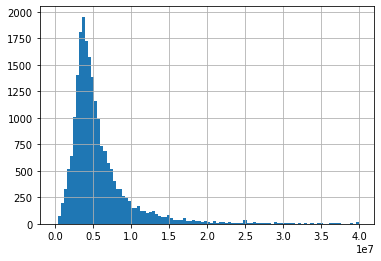

In [77]:
df['last_price'].hist(bins=100, range=(0,0.4e8))

<AxesSubplot:>

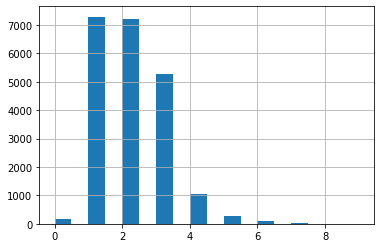

In [78]:
df['rooms'].hist(bins=18, range=(0,9))

<AxesSubplot:>

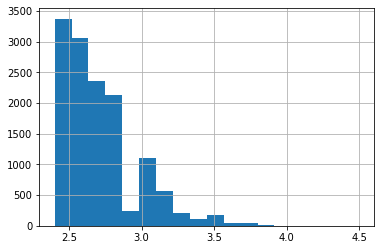

In [79]:
df['ceiling_height'].hist(bins=18, range=(2.4, 4.5))

<AxesSubplot:>

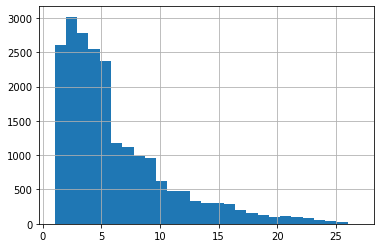

In [80]:
df['floor'].hist(bins=27, range=(1,27))

<AxesSubplot:>

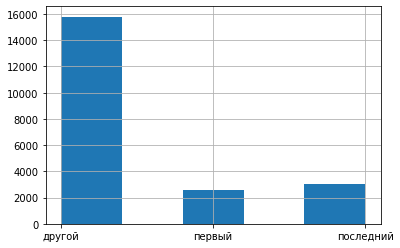

In [81]:
df['type_floor'].hist(bins=5)

<AxesSubplot:>

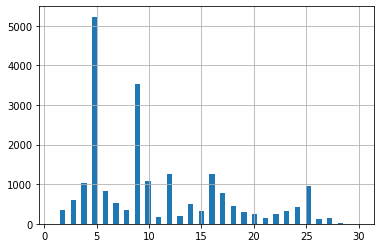

In [82]:
df['floors_total'].hist(bins=57, range=(1,30))

Типовая высотность - 5,9,12,16 и 25 этажей

<AxesSubplot:>

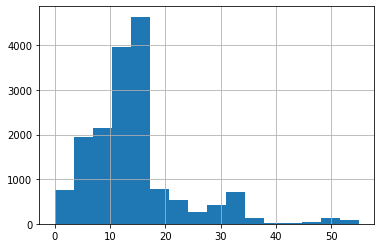

In [83]:
df['km_to_center'].hist(bins=16, range=(0, 55))

<AxesSubplot:>

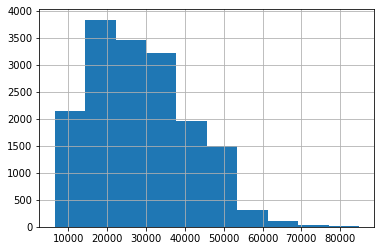

In [84]:
df['airports_nearest'].hist(bins=10)

<AxesSubplot:>

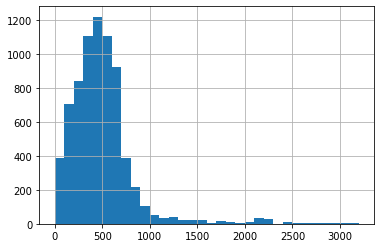

In [85]:
df['parks_nearest'].hist(bins=32, range=(0,3200))

<AxesSubplot:>

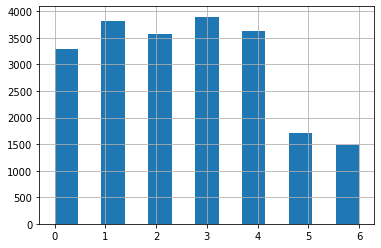

In [86]:
df['weekday_exposition'].hist(bins=13)

<AxesSubplot:>

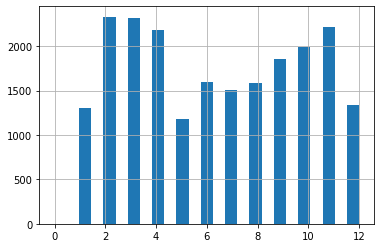

In [87]:
df['month_exposition'].hist(bins=25, range=(0,12))

- Основная часть объявлений - квартиры с площадью от 25 до 100 $м^2$, пик приходится примерно на 45 $м^2$
- По жилой площади квартиры большая часть объявления распределяется между 12 и 50 $м^2$, пик около 15 $м^2$
- Площадь кухни большинства квартир из объявлений находится в диапазоне от 5 до 16 $м^2$, пик примерно 8 $м^2$
- По цене оснавная часть объявлений распределена между 1 миллионом и 10 миллионами рублей, больше всего объявлений со стоимостью около 4 миллионов
- У большинства квартир из объявлений от 1 до 4 комнат, наибольше количество с 1 и 2 комнатами
- Высота потолков у большей части объявлений указана от 2.4 до 3.2 метров, пик - 2.4 метра
- Основная часть квартир из объявлений находится на этажах с 1 по 12, пик - 2 этаж
- На первом и последнем этаже примерно одинаковое количество квартир из объявлений, на других этажах примерно в 7 раз больше
- Большего всего квартир находится в домах с 5 и 9 этажами, также достаточно много с 4, 10, 12, 16 и 25 этажами
- По расстоянию от центра города большая часть объявлений распределена между 3 и 17 км, пик - примерно 17 км
- Аэропорт для большинства квартир находится на удалении примерно 5-52 км, пик - около 20 км
- Если расстояние до парка указано, то оно в основном от 0 до 700 метров, пик в районе 500 метров
- Объявления чаще размещали на будних днях, чем на выходных
- Чаще всего объявления размещали в Феврале, Марте, Апреле и Ноябре, а реже всего в Январе и Мае

<AxesSubplot:>

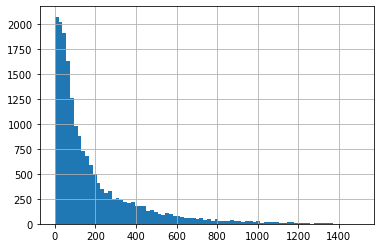

In [88]:
df['days_exposition'].hist(bins=80 , range=(0,1500))

In [89]:
df['days_exposition'].describe()

count    18487.000000
mean       182.698761
std        216.262075
min          3.000000
25%         44.000000
50%        100.000000
75%        237.000000
max       1368.000000
Name: days_exposition, dtype: float64

[]

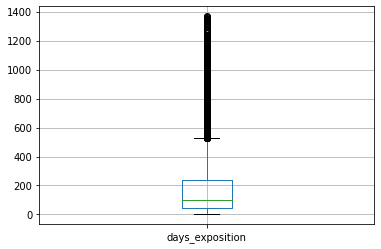

In [90]:
b_plot = df.boxplot(column = 'days_exposition')

b_plot.plot()

[]

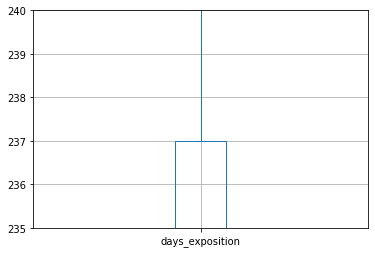

In [91]:
b_plot = df.boxplot(column = 'days_exposition')

plt.ylim(235,240)

b_plot.plot()

[]

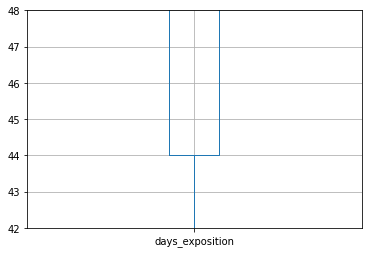

In [92]:
b_plot = df.boxplot(column = 'days_exposition')

plt.ylim(42,48)

b_plot.plot()

Судя по диаграмме размаха, продажа квартиры обычно занимает до 237 дней. Продажи, совершённые после истечению данного срока можно считать необычно долгими. А продажи совершенные быстрее, чем за 44 дней - быстрыми.

<AxesSubplot:xlabel='total_area', ylabel='last_price'>

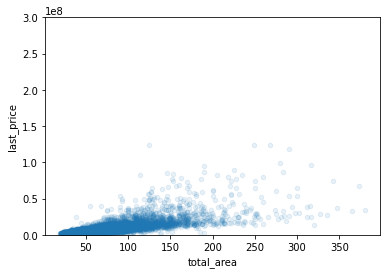

In [93]:

df.plot(ylim=(0,3e8), x='total_area', y='last_price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='living_area', ylabel='last_price'>

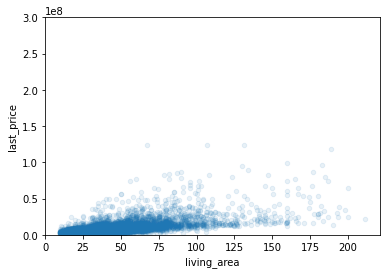

In [94]:
df.plot(ylim=(0,3e8), x='living_area', y='last_price', kind='scatter', alpha=0.1)

<AxesSubplot:xlabel='kitchen_area', ylabel='last_price'>

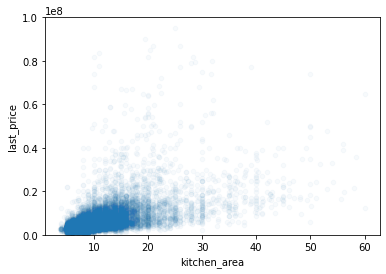

In [95]:
df.plot(ylim=(0,1e8), x='kitchen_area', y='last_price', kind='scatter', alpha=0.03)

In [96]:
price_rooms = df.pivot_table(index='rooms', values = 'last_price')

price_rooms

,last_price
rooms,
0,3.039861e+06
1,3.813026e+06
2,5.514405e+06
3,7.887023e+06
4,1.231510e+07
5,1.810319e+07
6,2.389947e+07
7,2.357750e+07
8,2.637667e+07


<AxesSubplot:xlabel='rooms'>

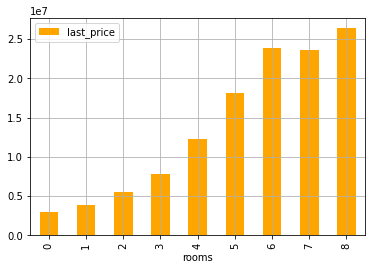

In [97]:
price_rooms.plot(grid=True, kind='bar', color='orange')

In [98]:
price_type_floor = df.pivot_table(index='type_floor', values = 'last_price')

price_type_floor

,last_price
type_floor,
другой,6.319104e+06
первый,4.724619e+06
последний,6.234191e+06


<AxesSubplot:xlabel='type_floor'>

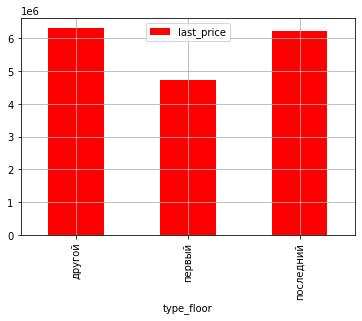

In [99]:
price_type_floor.plot(grid=True, kind='bar', color='red')

In [100]:
price_weekday = df.pivot_table(index='weekday_exposition', values='last_price')

price_weekday

,last_price
weekday_exposition,
0,6.215015e+06
1,5.978551e+06
2,6.034198e+06
3,6.372419e+06
4,6.068086e+06
5,5.967607e+06
6,6.022998e+06


<AxesSubplot:xlabel='weekday_exposition'>

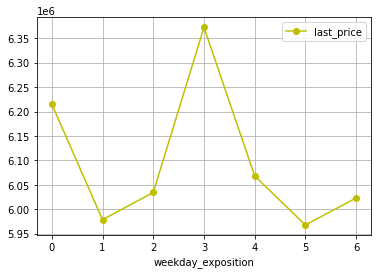

In [101]:
price_weekday.plot(grid=True, style='yo-')

In [102]:
price_month = df.pivot_table(index='month_exposition', values='last_price')

price_month

,last_price
month_exposition,
1,6.176972e+06
2,6.158941e+06
3,5.951577e+06
4,6.027135e+06
5,6.129671e+06
6,6.187227e+06
7,6.096261e+06
8,6.119557e+06
9,6.307247e+06


<AxesSubplot:xlabel='month_exposition'>

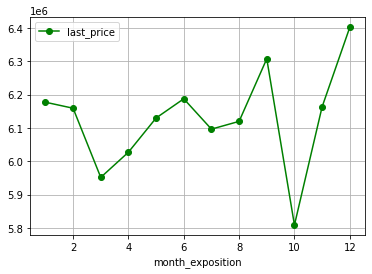

In [103]:
price_month.plot(grid=True, style='go-')

In [104]:
price_year = df.pivot_table(index='year_exposition', values='last_price')

price_year

,last_price
year_exposition,
2014,1.192682e+07
2015,7.450807e+06
2016,6.256792e+06
2017,5.987608e+06
2018,5.795848e+06
2019,6.404324e+06


<AxesSubplot:xlabel='year_exposition'>

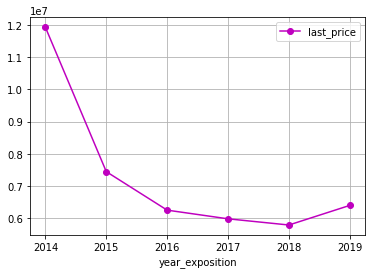

In [105]:
price_year.plot(grid=True, style='mo-')

In [106]:
df.pivot_table(index='year_exposition', values=['last_price', 'total_area'], aggfunc=['count', 'mean'])

count                     mean           
                last_price total_area    last_price total_area
year_exposition                                               
2014                   121        121  1.192682e+07  85.059752
2015                  1085       1085  7.450807e+06  68.404092
2016                  2623       2623  6.256792e+06  60.697419
2017                  7528       7528  5.987608e+06  59.091923
2018                  7410       7410  5.795848e+06  57.094582
2019                  2641       2641  6.404324e+06  57.652385

<AxesSubplot:xlabel='year_exposition'>

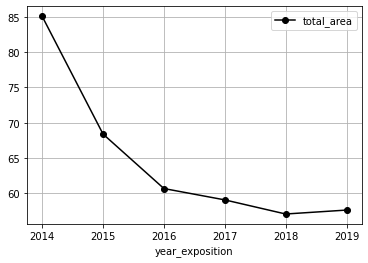

In [107]:
df.pivot_table(index='year_exposition', values='total_area').plot(grid=True, style='ko-')

Количество объявления в 2014 году было достаточно маленьким и с каждым годом росло, вплоть до 2018 года. В 2019 году объвления было почти в 3 раза меньше, чем в 2018.  
Средняя цена наоборот в 2014 году была намного больше, и падала с каждым годом. В 2019 году снова начала расти.  
График изменения средней площади квартир похож на график изменения средней стоимости. Площадь также была больше в 2014 году и падала до 2019 года.

In [108]:
df.corr().loc['last_price']

total_images           0.139093
last_price             1.000000
total_area             0.748023
rooms                  0.462278
ceiling_height         0.471485
floors_total           0.017728
living_area            0.656195
floor                  0.040703
is_apartment           0.014789
studio                -0.038824
open_plan             -0.027328
kitchen_area           0.552696
balcony                0.011182
airports_nearest      -0.036715
cityCenters_nearest   -0.298287
parks_around3000       0.272640
parks_nearest         -0.013515
ponds_around3000       0.277055
ponds_nearest         -0.115254
days_exposition        0.104815
square_meter_price     0.739714
weekday_exposition    -0.003311
month_exposition       0.004888
year_exposition       -0.046364
km_to_center          -0.298787
Name: last_price, dtype: float64

In [109]:
ind = df['new_locality_name'].value_counts().head(10).index

average_price_square_meter = df.query('new_locality_name in @ind').pivot_table(index='new_locality_name', values='square_meter_price').sort_values(by='square_meter_price', ascending=False)

average_price_square_meter

,square_meter_price
new_locality_name,
Санкт-Петербург,112541.628084
Пушкин,102743.459472
Кудрово,95648.661723
поселок Парголово,90404.750482
Мурино,86571.713695
Петергоф,84480.969944
поселок Шушары,78730.280416
Колпино,75344.096345
Всеволожск,68916.518798


<AxesSubplot:xlabel='new_locality_name'>

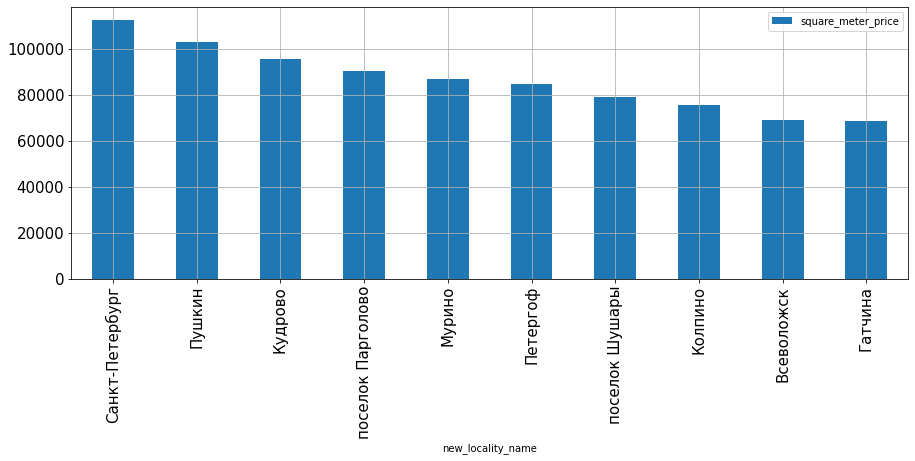

In [110]:
average_price_square_meter.plot(grid=True, kind='bar', figsize = (15,5), fontsize = 15)

In [111]:
average_price_square_meter.idxmax()

square_meter_price    Санкт-Петербург
dtype: object

In [112]:
average_price_square_meter.idxmin()

square_meter_price    Гатчина
dtype: object

In [113]:
price_km_to_center = df.query('new_locality_name == "Санкт-Петербург"').pivot_table(index='km_to_center', values='last_price')

price_km_to_center

,last_price
km_to_center,
0.0,2.367724e+07
1.0,1.598401e+07
2.0,1.535110e+07
3.0,1.067073e+07
4.0,1.102139e+07
5.0,1.170981e+07
6.0,1.278794e+07
7.0,1.366311e+07
8.0,9.216295e+06


<AxesSubplot:xlabel='km_to_center'>

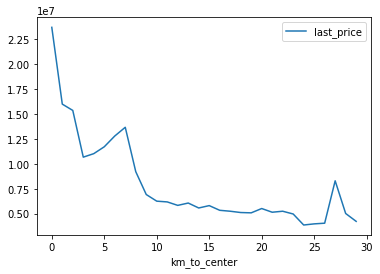

In [114]:
price_km_to_center.plot()

<AxesSubplot:xlabel='km_to_center'>

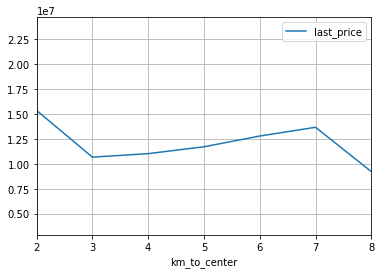

In [115]:
price_km_to_center.plot(grid=True, xlim=(2,8))

In [116]:
pd.set_option('display.max_rows', None) 

floor_km_to_center = df.query('new_locality_name == "Санкт-Петербург"').groupby(['km_to_center', 'type_floor'])['type_floor'].count()

floor_km_to_center

km_to_center  type_floor
0.0           другой          11
              первый           2
              последний        4
1.0           другой         101
              первый          23
              последний       41
2.0           другой         155
              первый          40
              последний       74
3.0           другой         189
              первый          52
              последний       73
4.0           другой         442
              первый          69
              последний      105
5.0           другой         597
              первый          70
              последний      120
6.0           другой         380
              первый          59
              последний       81
7.0           другой         296
              первый          28
              последний       56
8.0           другой         434
              первый          50
              последний       66
9.0           другой         407
              первый          50
              посл

In [117]:
df.query('new_locality_name == "Санкт-Петербург"').pivot_table(index='km_to_center', values='kitchen_area')

,kitchen_area
km_to_center,
0.0,17.276471
1.0,14.136918
2.0,15.403798
3.0,13.607888
4.0,13.383564
5.0,14.200615
6.0,13.602390
7.0,13.280970
8.0,12.200190


Судя по таблице, выброс на 27 километре может быть обусловлен отсутсвием объявлений по продаже квартир на 1 этаже.

### Общий вывод

1. Стоимость квартиры сильно зависит от населенного пункта 
2. Стоимость квартир сильно зависит от площадей, как видно из графиков, чем больше площадь (общая, жилая, кухни), тем квартира дороже
3. С увеличением числа комнат растёт число объявлений с более дорогими квартирами
4. Квартиры на первом этаже дешевле, чем на других
5. После 2014 года стало больше более дорогих объявлений, с каждым годом эта тендеция сохранялась, вплоть до 2017 года, после объявления стали дешевле
6. Из популярных населённых пунктов наибольшую цену за квадратный метр имеет Санкт-Петербург, а наименьшую - Гатчина
7. В основном, чем ближе к центру, тем квартиры дороже
